In [ ]:
import pandas as pd
from ast import literal_eval
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from keras.layers import Masking, LSTM, Dense, Activation

In [2]:
df = pd.read_csv('music_embedding_2.tsv')
df['music_embedding'] = df['music_embedding'].apply(literal_eval)
df['genre_embedding'] = df['genre_embedding'].apply(literal_eval)
df.head(3)

,author_id,disorder,music_embedding,genre_embedding
0,1000026915590189062,control,"[-0.030979907140135765, 0.01254077535122633, 0...","[0, 0, 0, 0, 0, 1]"
1,1000123379356233729,control,"[0.007308566011488438, -0.03472823277115822, 0...","[1, 0, 0, 0, 0, 0]"
2,1000123379356233729,control,"[-0.017335733398795128, 0.05415014922618866, 0...","[0, 0, 0, 1, 0, 0]"


In [3]:
len(list(df.iloc[:1]["music_embedding"])[0])

778

In [4]:
max_sessions = 100

In [5]:
processed_users = 0

def prepare_sequences(data):
    
    global processed_users
    
    sequences = []
    labels = []
    
    for user_data in data.groupby('author_id'):
        
        user_df = user_data[1]
        
        if len(user_df) >= 5 :
            
            processed_users += 1
            
            user_dict = dict(user_df.iloc[0])
            
            is_control = 0
            
            if user_dict['disorder'] == 'control':
                
                is_control = 1
            
            temp_sequence = []
                
            count = 0
            
            for index, row in user_df.tail(max_sessions + 1).iterrows():
                
                if count == len(user_df) - 1 or count == max_sessions:
                    labels.append(row["genre_embedding"])
                    
                else:
                    sequence_embedding = [is_control] + row['music_embedding'].copy()
                    temp_sequence.append(sequence_embedding)
                    count += 1
                
            sequences.append(temp_sequence)
        
    return sequences, labels

In [6]:
# Prepare sequences and labels
sequences, labels = prepare_sequences(df.copy())

for i, sequence in enumerate(sequences):
    if len(sequence) < max_sessions:
        padding_array = [0] * 779
        for j in range(0, (max_sessions - len(sequence))):
            sequences[i].append(padding_array)


labels = np.array(labels)
sequences = np.array(sequences)

In [7]:
print(labels.shape)
print(sequences.shape)


(2481, 6)
(2481, 100, 779)


In [8]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopper = EarlyStopping(monitor='val_loss',  
                              patience=10,  
                              verbose=1,
                              mode='min',
                              restore_best_weights=True)   


Epoch 1/30
47/47 [==============================] - 24s 365ms/step - loss: 1.4988 - accuracy: 0.3851 - val_loss: 1.3583 - val_accuracy: 0.4677
Epoch 2/30
47/47 [==============================] - 12s 259ms/step - loss: 1.3825 - accuracy: 0.4530 - val_loss: 1.3334 - val_accuracy: 0.4798
Epoch 3/30
47/47 [==============================] - 12s 262ms/step - loss: 1.3584 - accuracy: 0.4677 - val_loss: 1.4018 - val_accuracy: 0.4536
Epoch 4/30
47/47 [==============================] - 12s 262ms/step - loss: 1.3470 - accuracy: 0.4825 - val_loss: 1.3168 - val_accuracy: 0.5101
Epoch 5/30
47/47 [==============================] - 12s 259ms/step - loss: 1.3398 - accuracy: 0.4805 - val_loss: 1.3496 - val_accuracy: 0.4940
Epoch 6/30
47/47 [==============================] - 12s 262ms/step - loss: 1.3143 - accuracy: 0.4980 - val_loss: 1.2740 - val_accuracy: 0.5565
Epoch 7/30
47/47 [==============================] - 12s 259ms/step - loss: 1.3051 - accuracy: 0.5094 - val_loss: 1.2746 - val_accuracy: 0.5403

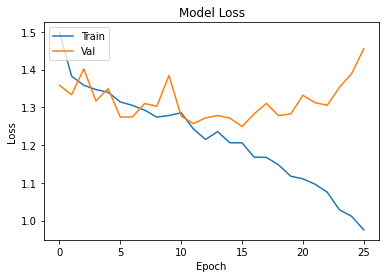

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Masking, GRU, Dense
from imblearn.over_sampling import RandomOverSampler

y_true_labels = np.argmax(labels, axis=1)


X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)



batch_size = 32

# Define the LSTM model
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(max_sessions, 779)))
model.add(LSTM(128, return_sequences=True, dropout=0.2)) 
model.add(LSTM(128, dropout=0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='softmax'))

# Compile the model with weighted loss
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopper]) 


loss, accuracy = model.evaluate(X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import OneHotEncoder

# unique_genres = ["Pop", "Rock", "Hip Hop"]
unique_genres = ["Pop", "Rock", "Electronic", "Hip Hop", "Jazz", "Others"]

y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)


f1_scores = f1_score(y_true_labels, y_pred_labels, average=None)

print("Confusion Matrix:")
print(conf_matrix)

print("F1 Score for Each Group:")

for i, genre in enumerate(unique_genres):
    print(f"{genre}: {f1_scores[i]}")
  

/home/zeinab/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zeinab/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


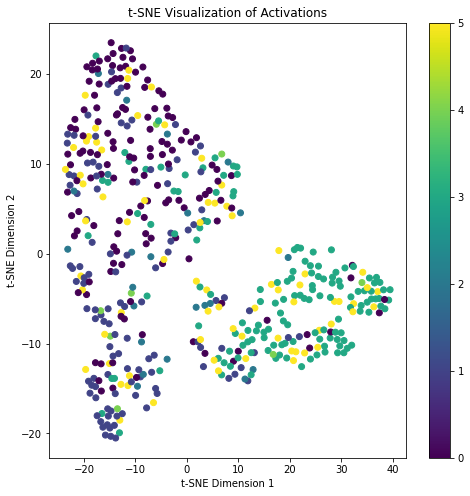

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from keras.models import Model

extractor = Model(inputs=model.inputs, outputs=model.layers[-2].output) 

# Extract activations for the validation set
activations_val = extractor.predict(X_val)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30)
activations_tsne = tsne.fit_transform(activations_val)

# Plot t-SNE embeddings
plt.figure(figsize=(8, 8))
plt.scatter(activations_tsne[:, 0], activations_tsne[:, 1], c=np.argmax(y_val, axis=1), cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Activations')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_genres, yticklabels=unique_genres)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Adding Attention Layer

In [ ]:
from keras.models import Model
import tensorflow as tf
from keras.layers import Layer


class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.dot(x, self.W) + self.b
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        context_vector = tf.reduce_sum(output, axis=1)
        return context_vector

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [ ]:
from keras.layers import Input, Masking, LSTM, Dense, AdditiveAttention
from keras.models import Model
import tensorflow as tf
from keras.layers import Layer


y_true_labels = np.argmax(labels, axis=1)

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_true_labels),
                                        y = y_true_labels                                                    
                                    )
class_weights_dict = dict(zip(np.unique(y_true_labels), class_weights))

X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) 


X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)


batch_size = 32

# Modify the Model Architecture
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(max_sessions, 776)))
model.add(LSTM(128, return_sequences=True, dropout=0.2))
model.add(LSTM(128, return_sequences=True, dropout=0.2)) 
model.add(AttentionLayer())  # Add Attention Layer
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopper], class_weight=class_weights_dict) 


loss, accuracy = model.evaluate(X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()



In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import OneHotEncoder

y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)


f1_scores = f1_score(y_true_labels, y_pred_labels, average=None)



print("Confusion Matrix:")
print(conf_matrix)

print("F1 Score for Each Group:")
for i, genre in enumerate(unique_genres):
    print(f"{genre}: {f1_scores[i]}")


In [ ]:
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
f1

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_genres, yticklabels=unique_genres)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print(len(y_test))


unique_genres = ["Pop", "Rock", "Hip Hop"]

genre_counts = {genre: 0 for genre in unique_genres}

list_y_test = list(y_test)

for row in list_y_test:
    
    row = list(row)
    
    genre_index = row.index(1)
    
    genre_counts[unique_genres[genre_index]] += 1

for genre, count in genre_counts.items():
    
    print(f"{genre}: {count}")

In [ ]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_true_labels),
                                        y = y_true_labels                                                    
                                    )
class_weights_dict = dict(zip(np.unique(y_true_labels), class_weights))
print(class_weights_dict)